# Установка необходимых библиотек

In [ ]:
!pip install librosa

In [ ]:
!pip install tensorflow

In [40]:
import librosa #Для параметризации аудио
import IPython.display as ipd #Для проигрывания аудио
import matplotlib.pyplot as plt #Для отрисовки графиков
import librosa.display #Для отображения аудио сигналов
import numpy as np
#from librosa.output import write_wav
#from librosa import output
import soundfile as sf

# красивый Progress_board
from tqdm import tqdm_notebook

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM 
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import os

# Feature Enineering

## Звуки срабатывания ПСК на 50%, на 100%, посторонние шумы, голоса и фоновые шумы. (4 класса)

In [2]:
audio_path = 'C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/1226 obuch17052021.wav'

#Загрузаем аудио
x, sr = librosa.load(audio_path) #x - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
#Выводим данные по сигналу
print(type(x), type(sr))
print(x.shape[0], '- Всего значений')
print(sr, '- Частота дискритизации (зн/сек)')
print(x.shape[0]/sr, '- Длительность (сек)')

<class 'numpy.ndarray'> <class 'int'>
79380000 - Всего значений
22050 - Частота дискритизации (зн/сек)
3600.0 - Длительность (сек)


In [3]:
x_plot = np.absolute(x)
len_x_plot = x_plot[::22050].shape[0] + 600

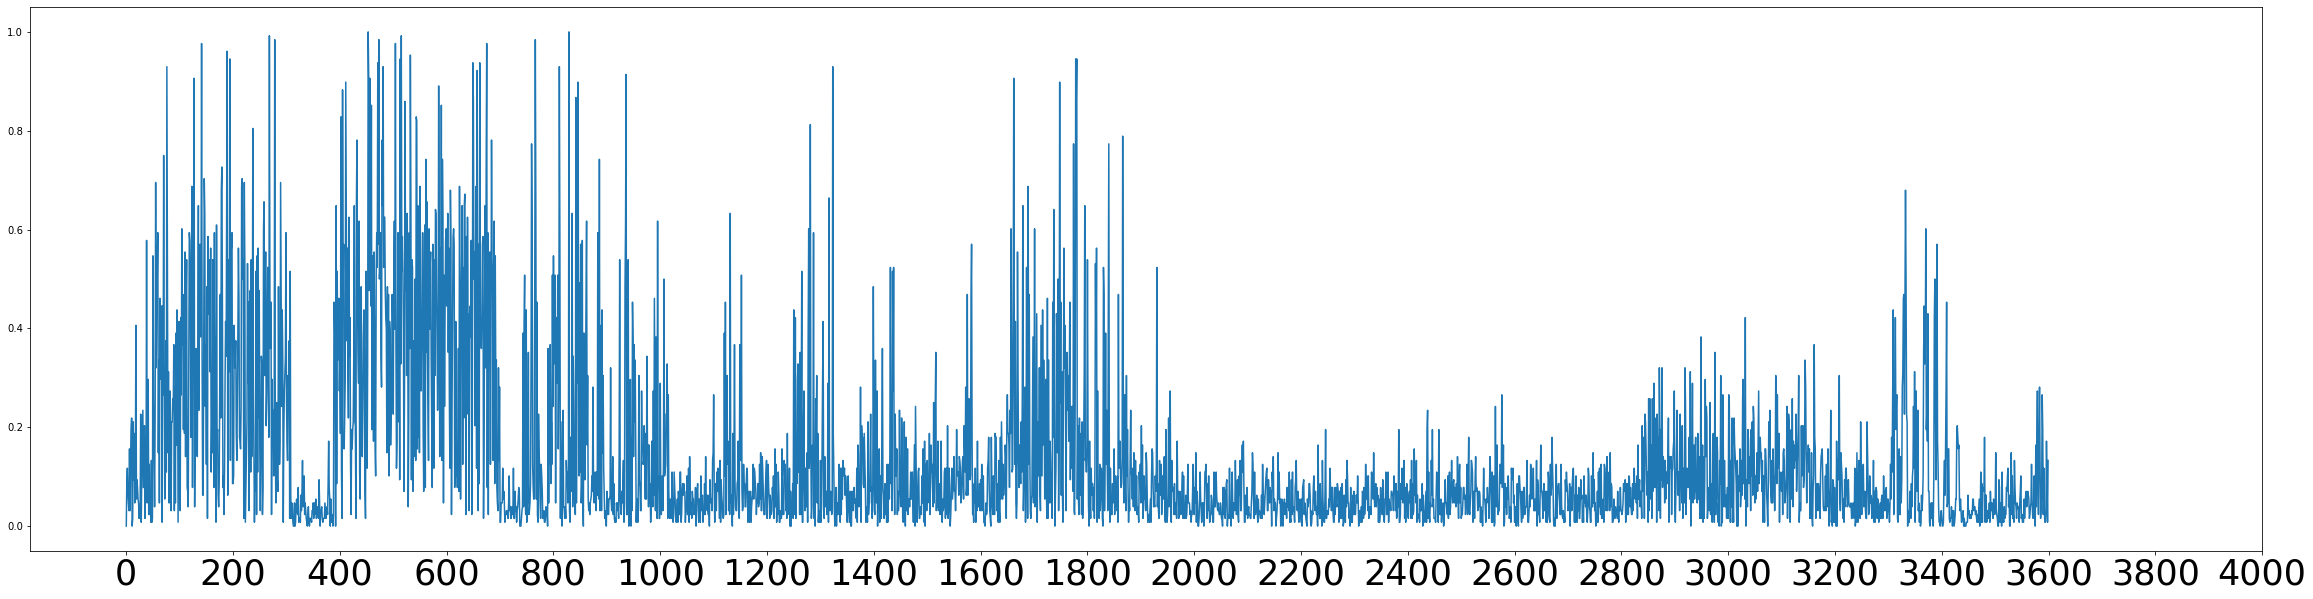

In [4]:
##########################
# Выводим сигнал на экран.
##########################

plt.figure(figsize=(40, 10))

plt.plot(x_plot[::22050]) # выводим последнее значение каждой секунды

plt.xticks(fontsize=35, ticks=range(0, len_x_plot, 200))

plt.show()

**Распилим нашу дорожку надвое, по границе в 2000 секунд, т.к. далее наблюдается резкая смена характера звука** 

In [5]:
print(f'{x.shape[0]} - общее кол-во значений во всей дорожке длительностью 3600 сек')

79380000 - общее кол-во значений во всей дорожке длительностью 3600 сек


In [6]:
split_line = 2000 * 22050
print(f'{split_line} - кол-во значений до границы разреза')

44100000 - кол-во значений до границы разреза


In [7]:
part1 = x[:split_line]
print(f'{part1.shape[0]} - кол-во значений ДО границы разреза')

part2 = x[split_line:]
print(f'{part2.shape[0]} - кол-во значений ПОСЛЕ границы разреза')

print(f'{part2.shape[0] + part1.shape[0]} - общее кол-во значений')

44100000 - кол-во значений ДО границы разреза
35280000 - кол-во значений ПОСЛЕ границы разреза
79380000 - общее кол-во значений


**Сохранение обоих частей**

In [8]:
sf.write('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/part1.wav', part1, sr)

In [9]:
sf.write('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/part2.wav', part2, sr)

In [10]:
audio_path = 'C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/part1.wav'

#Загрузаем аудио
x_part1, sr = librosa.load(audio_path) #x - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
#Выводим данные по сигналу
print(type(x_part1), type(sr))
print(x_part1.shape[0], '- Всего значений')
print(sr, '- Частота дискритизации (зн/сек)')
print(x_part1.shape[0]/sr, '- Длительность (сек)')

<class 'numpy.ndarray'> <class 'int'>
44100000 - Всего значений
22050 - Частота дискритизации (зн/сек)
2000.0 - Длительность (сек)


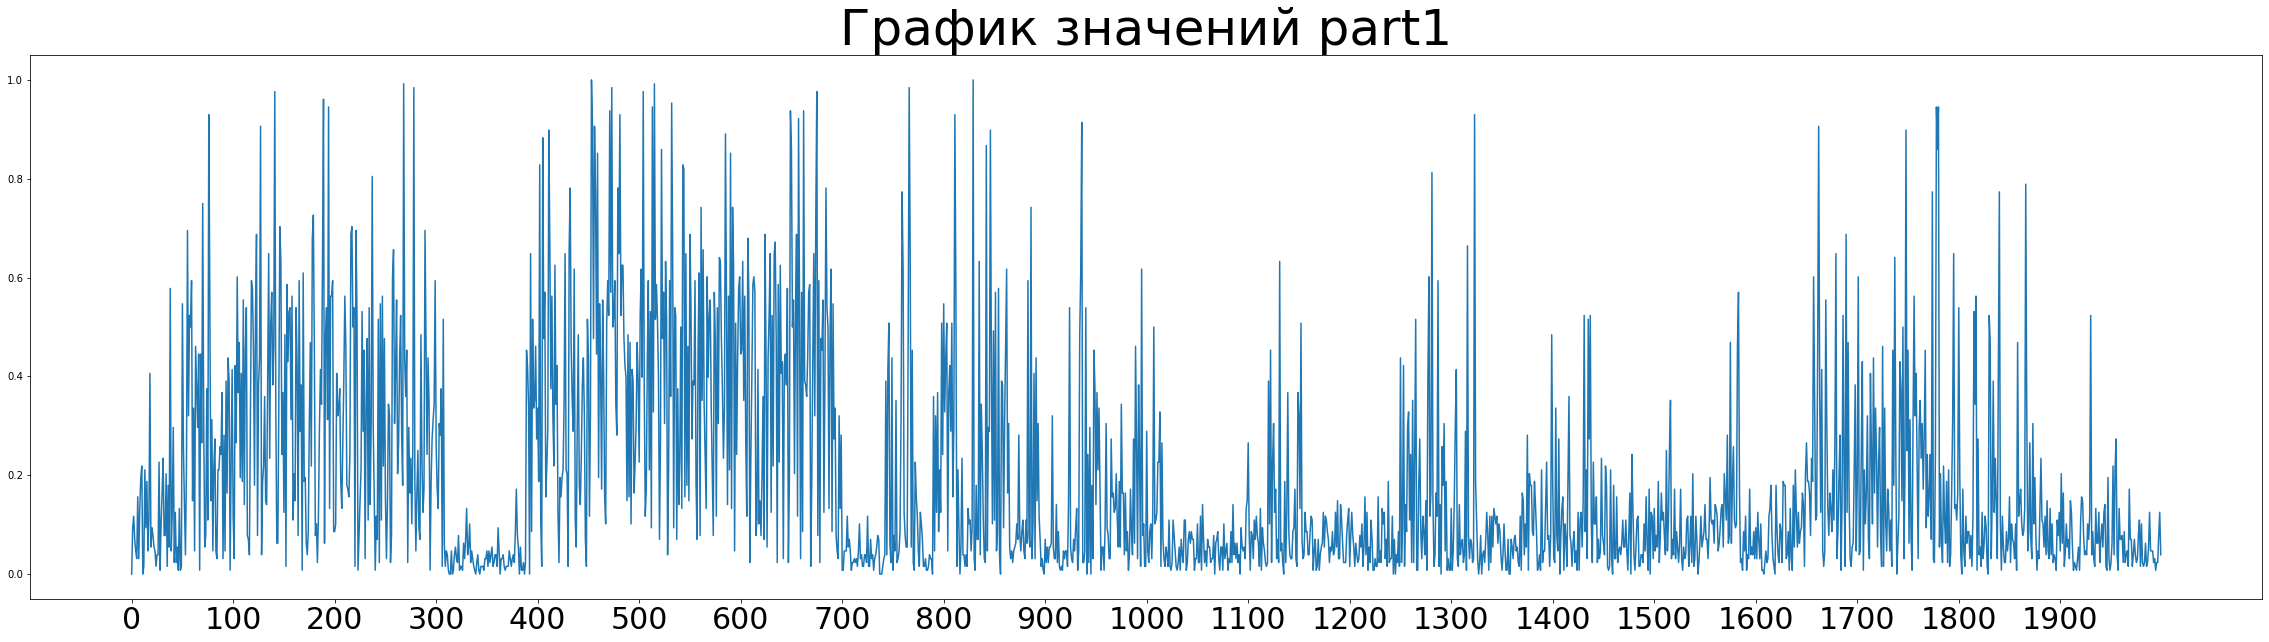

In [11]:
x_plot = np.absolute(x_part1)
len_x_plot = x_plot[::sr].shape[0]

plt.figure(figsize=(40, 10))

plt.title('График значений part1', fontsize = 50)

plt.plot(x_plot[::sr]) # выводим последнее значение каждой секунды

plt.xticks(fontsize=30, ticks=range(0, len_x_plot, 100))

plt.show()

## Вывод по таймингам

In [12]:
# 50 - 300 / 50%   250сек
# 390 - 690 / 100%  300 сек
# 744 - 900 / ШУМЫ  156 сек
# 925 - 1020 & 1120 - 1155 & 1260 - 1300 / голоса 170 сек

In [13]:
'''
Вследствие того что звуки шумов очень уникальны берём нижний предел в 155 секунд, т.е.
Создадим 4 массива для каждого класса звуков длинной в 155 секнд, а затем произведем
аугментацию данных в обучающие примеры с помощью скользящего окна.

'''
print()

In [14]:
#################################################
# Создание словарей для удобста работы с данными.
#################################################

time_dict_sec = {
    'psk_50': np.array([50, 205]),
    'psk_100': np.array([390, 545]),
    'noises': np.array([744, 899]),
    'voises': np.array([925, 1020, 1120, 1155, 1260, 1285])  
}

time_dict_enc = {}

time_dict_enc['psk_50']  = time_dict_sec['psk_50'] * sr
time_dict_enc['psk_100'] = time_dict_sec['psk_100'] * sr
time_dict_enc['noises']  = time_dict_sec['noises'] * sr
time_dict_enc['voises']  = time_dict_sec['voises'] * sr


In [15]:
time_dict_enc

{'psk_50': array([1102500, 4520250]),
 'psk_100': array([ 8599500, 12017250]),
 'noises': array([16405200, 19822950]),
 'voises': array([20396250, 22491000, 24696000, 25467750, 27783000, 28334250])}

## Обрезка значений под интервал в 155 сек первых четырех классов

### ПСК на 50%

In [16]:
x_part1.shape

(44100000,)

In [17]:
low = time_dict_enc['psk_50'][0]
hight = time_dict_enc['psk_50'][1]

data_psk_50 = x_part1[low:hight]

print(data_psk_50.shape[0], '- кол-во элементов')
data_psk_50[:20]

3417750 - кол-во элементов


array([ 0.546875 , -0.109375 , -0.546875 ,  0.25     ,  0.359375 ,
       -0.3984375, -0.4296875,  0.265625 ,  0.625    ,  0.1484375,
       -0.2890625, -0.4765625, -0.4375   ,  0.109375 ,  0.234375 ,
        0.046875 ,  0.1953125, -0.015625 , -0.4609375, -0.328125 ],
      dtype=float32)

### ПСК на 100%

In [18]:
low = time_dict_enc['psk_100'][0]
hight = time_dict_enc['psk_100'][1]

data_psk_100 = x_part1[low:hight]

print(data_psk_100.shape[0], '- кол-во элементов')
data_psk_100[:20]

3417750 - кол-во элементов


array([-0.421875 ,  0.5390625,  0.625    , -0.1953125, -0.5390625,
       -0.3828125, -0.0546875,  0.3828125,  0.4453125, -0.09375  ,
       -0.375    , -0.1015625, -0.1640625, -0.3828125,  0.3046875,
        0.5703125, -0.296875 , -0.515625 ,  0.109375 ,  0.2421875],
      dtype=float32)

### noises

In [19]:
low = time_dict_enc['noises'][0]
hight = time_dict_enc['noises'][1]

data_noises = x_part1[low:hight]

print(data_noises.shape[0], '- кол-во элементов')
data_noises[:20]

3417750 - кол-во элементов


array([-0.0390625,  0.       ,  0.0390625,  0.0546875,  0.046875 ,
       -0.015625 , -0.078125 , -0.0234375,  0.09375  ,  0.1015625,
        0.03125  , -0.0390625, -0.09375  , -0.0859375,  0.03125  ,
        0.1171875,  0.0234375, -0.0546875,  0.015625 ,  0.046875 ],
      dtype=float32)

### voises

**В речи часто были пробелы, поэтому пришлось собирать воедино отдельные фрагменты, где оператор говорит непрерывно**

In [20]:
low1   = time_dict_enc['voises'][0]
hight1 = time_dict_enc['voises'][1]
low2   = time_dict_enc['voises'][2]
hight2 = time_dict_enc['voises'][3]
low3   = time_dict_enc['voises'][4]
hight3 = time_dict_enc['voises'][5]

span1 = x_part1[low1:hight1]
span2 = x_part1[low2:hight2]
span3 = x_part1[low3:hight3]

data_voises = np.concatenate((span1, span2), axis=0)
data_voises = np.concatenate((data_voises, span3), axis=0)

print(data_voises.shape[0], '- кол-во элементов')
data_voises[:20]

3417750 - кол-во элементов


array([ 0.0546875, -0.046875 , -0.0234375,  0.09375  ,  0.078125 ,
       -0.0703125, -0.1171875, -0.046875 ,  0.046875 ,  0.078125 ,
        0.03125  ,  0.       ,  0.       ,  0.0390625,  0.0390625,
       -0.0546875, -0.0546875,  0.109375 ,  0.1484375,  0.015625 ],
      dtype=float32)

### Фоновый шум

In [21]:
audio_path = 'C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/1226 obuch_fon17052021.wav' 

x_noise, sr = librosa.load(audio_path) #x - массив данных временного ряда аудио, sr - частота дискретизации временного ряда

#Выводим данные по сигналу
print(type(x_noise), type(sr))
print(x_noise.shape[0], '- Всего значений')
print(sr, '- Частота дискритизации (зн/сек)')
print(x_noise.shape[0]/sr, '- Длительность (сек)')

<class 'numpy.ndarray'> <class 'int'>
19845000 - Всего значений
22050 - Частота дискритизации (зн/сек)
900.0 - Длительность (сек)


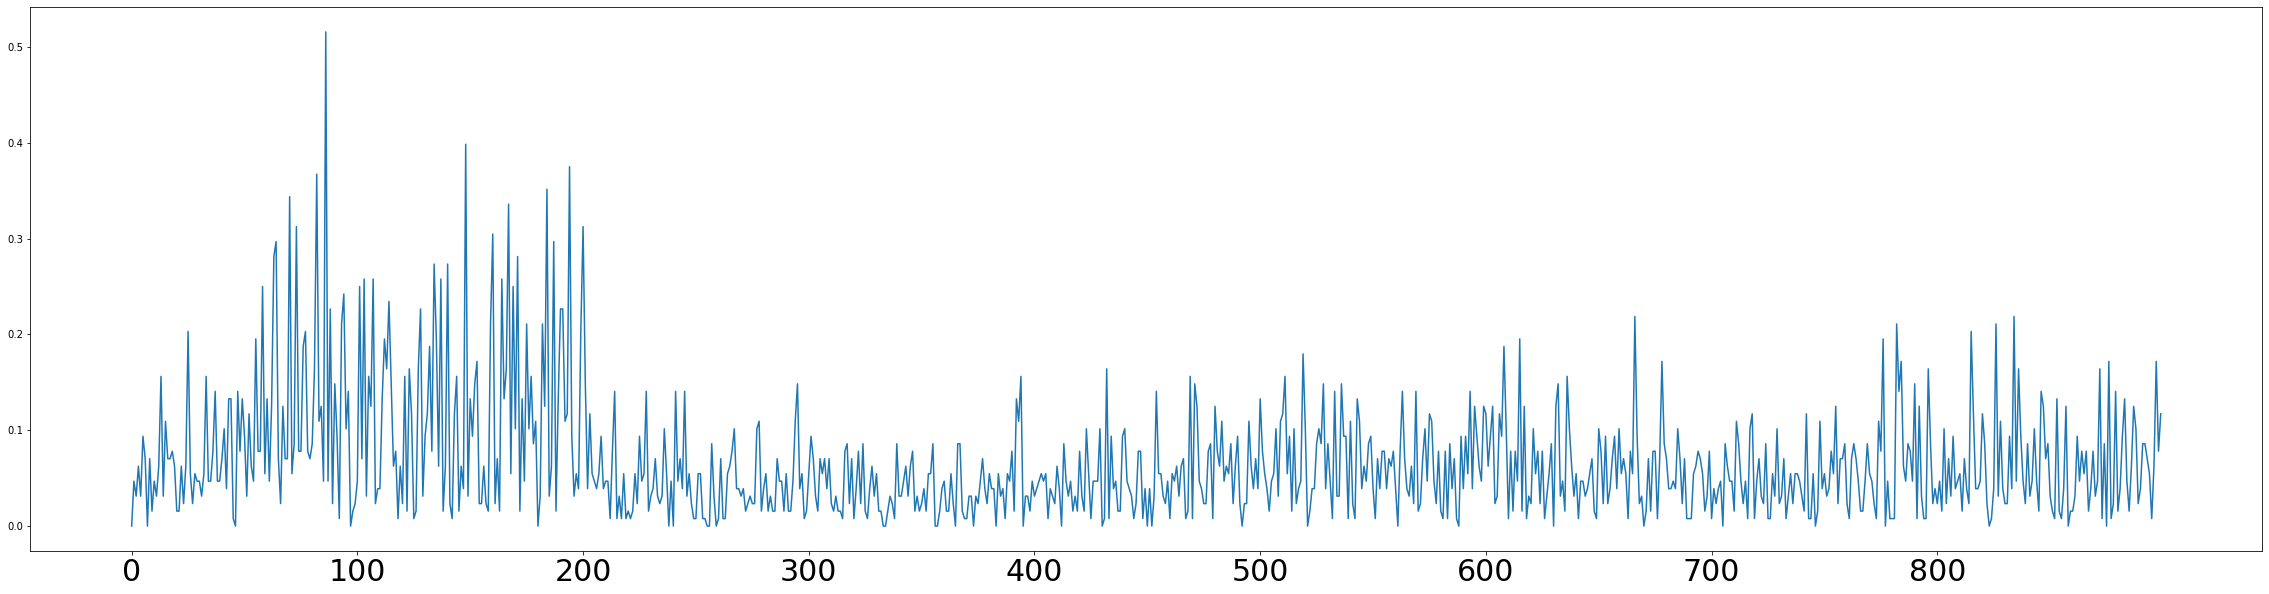

In [22]:
x_plot = np.absolute(x_noise)
len_x_plot = x_plot[::22050].shape[0]


plt.figure(figsize=(40, 10))

plt.plot(x_plot[::22050])

plt.xticks(fontsize=30, ticks=range(0, len_x_plot, 100))

plt.show()

**Выбран интервал, в котором максимально разнообразно изменяется звук**

In [23]:
 time_dict_sec['back_noise'] = np.array([30, 185])

In [24]:
time_dict_enc['back_noise'] = time_dict_sec['back_noise'] * sr

In [25]:
time_dict_enc

{'psk_50': array([1102500, 4520250]),
 'psk_100': array([ 8599500, 12017250]),
 'noises': array([16405200, 19822950]),
 'voises': array([20396250, 22491000, 24696000, 25467750, 27783000, 28334250]),
 'back_noise': array([ 661500, 4079250])}

In [26]:
low = time_dict_enc['back_noise'][0]
hight = time_dict_enc['back_noise'][1]

data_back_noise = x_noise[low:hight]

print(data_back_noise.shape[0], '- кол-во элементов')
data_back_noise[:20]

3417750 - кол-во элементов


array([-0.046875 ,  0.015625 ,  0.0625   ,  0.046875 ,  0.       ,
       -0.03125  , -0.0703125, -0.046875 ,  0.03125  ,  0.0078125,
       -0.078125 , -0.0625   ,  0.0625   ,  0.0859375, -0.0859375,
       -0.1328125, -0.015625 , -0.0078125, -0.0234375,  0.0390625],
      dtype=float32)

### no_sound

In [27]:
audio_path = 'C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/microphoneout.wav' 

x_no, sr = librosa.load(audio_path) # x - массив данных временного ряда аудио, sr - частота дискретизации временного ряда

#Выводим данные по сигналу
print(type(x_no), type(sr))
print(x_no.shape[0], '- Всего значений')
print(sr, '- Частота дискритизации (зн/сек)')
print(x_no.shape[0]/sr, '- Длительность (сек)')

<class 'numpy.ndarray'> <class 'int'>
661500 - Всего значений
22050 - Частота дискритизации (зн/сек)
30.0 - Длительность (сек)


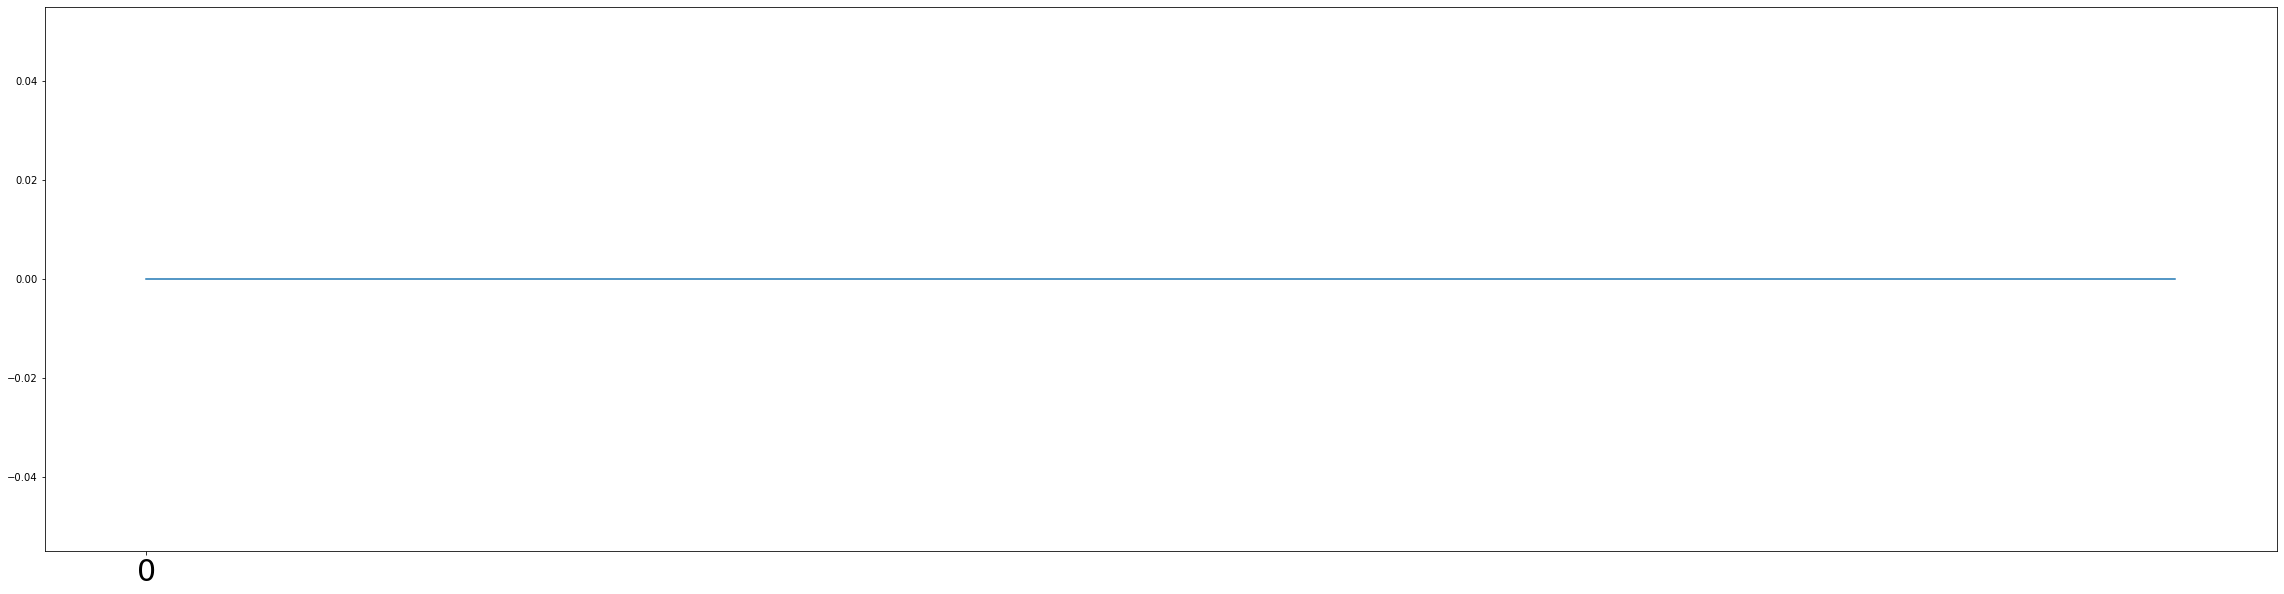

In [28]:
x_plot = np.absolute(x_no)
len_x_plot = x_plot[::22050].shape[0]


plt.figure(figsize=(40, 10))

plt.plot(x_plot[::22050]) # выводим последнее значение каждой секунды

plt.xticks(fontsize=30, ticks=range(0, len_x_plot, 100))

plt.show()

In [29]:
data_no = np.zeros(data_back_noise.shape)
print(data_no.shape)

(3417750,)


## Создание Samples, т.е. коротких фрагментов каждого класса, на базе которых будут формироваться обучающая и проверочная выборки

In [30]:
print(sr, ' - Частота дискритизации')

22050  - Частота дискритизации


In [31]:
################################################
# Функция формирования сэмплов для одного класса.
################################################

def create_samples(data, xLen, step):
    
    '''
    Входные параметры: 
    - data - массив значений одного класса
    - xLen - размер окна
    - step - шаг окна
    
    Выходные параметры:
    - xSample - массив примеров данного класса
    
    ''' 
    xSample = []         
    data_len = len(data)
    index = 0            

    while (index + xLen <= data_len):          # Идём по всей длине массива значений
        xSample.append(data[index:index+xLen]) # "Откусываем" пример длинной xLen
        index += step                          # Смещаеммся вперёд на step
    
    return np.array(xSample)

In [32]:
time_dict_sec

{'psk_50': array([ 50, 205]),
 'psk_100': array([390, 545]),
 'noises': array([744, 899]),
 'voises': array([ 925, 1020, 1120, 1155, 1260, 1285]),
 'back_noise': array([ 30, 185])}

In [33]:
#################################################
# Создание словарей для удобста работы с данными.
#################################################

data_dict = {
    'psk_50'       : data_psk_50,
    'psk_100'      : data_psk_100,
    'noises'       : data_noises,
    'voises'       : data_voises,
    'back_noise'   : data_back_noise,
    'data_no_sound': data_no
}

num_class_dict = {
    'psk_50'       : 0,
    'psk_100'      : 1,
    'noises'       : 2,
    'voises'       : 3,
    'back_noise'   : 4,
    'data_no_sound': 5
}

In [34]:
##########################################################
# Функция формирования сэмплов и лейблов для всех классов.
##########################################################

def samples_lables(data_dict, xLen, step):

    '''
    Входные параметры: 
    - data_dict - словарь с массивами данных по каждому классу
    - xLen - размер окна
    - step - шаг окна
    
    Выходные параметры:
    - numpy массив сэмплов для каждого класса и numpy массив лейблов по каждому классу
    
    '''        
    all_samples = []
    all_lables  = []
    
    for name_cl, data_cl in data_dict.items():
        samples_cl = create_samples(data_cl, xLen, step) # samples_cl.shape = (153, 66150)
        for samp in samples_cl:
            all_samples.append(samp)
            all_lables.append(num_class_dict[name_cl])

    return np.array(all_samples), np.array(all_lables)


In [35]:
data_dict

{'psk_50': array([ 0.546875 , -0.109375 , -0.546875 , ..., -0.5234375,  0.125    ,
         0.8984375], dtype=float32),
 'psk_100': array([-0.421875 ,  0.5390625,  0.625    , ..., -0.15625  ,  0.671875 ,
         0.59375  ], dtype=float32),
 'noises': array([-0.0390625,  0.       ,  0.0390625, ..., -0.03125  ,  0.       ,
        -0.0234375], dtype=float32),
 'voises': array([ 0.0546875, -0.046875 , -0.0234375, ..., -0.234375 , -0.046875 ,
        -0.0078125], dtype=float32),
 'back_noise': array([-0.046875 ,  0.015625 ,  0.0625   , ...,  0.078125 ,  0.0703125,
         0.015625 ], dtype=float32),
 'data_no_sound': array([0., 0., 0., ..., 0., 0., 0.])}

**Возьмём ширину окна в ТРИ секунды и шаг в ОДНУ секунду**

In [36]:
x_samples, y_lables = samples_lables(data_dict, 3*sr, 1*sr)

In [37]:
print(x_samples.shape, '- Размерность сэмплов')
print(y_lables.shape, '- Размерность лейблов')

(918, 66150) - Размерность сэмплов
(918,) - Размерность лейблов


# Формирование X_train & Y_train

In [38]:
######################################################################
# Функция параметризации аудио, тоесть выделение фич из одного сэмпла.
######################################################################

def get_features(y, sr):

    '''
    Входные параметры: 
    - y - один сэмпл
    - sr - частота дискритизации
    
    Выходные параметры:
    - фичи одного сэпла размерностью (37, 0), что и есть один пример для X_train
    
    '''       
    #Получаем различные параметры аудио
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
    mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
    rmse = np.mean(librosa.feature.rms(y=y))                            #Среднеквадратичная амплитуда
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))  #среднее спектральныго центроида
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))   #среднее ширины полосы частот
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))     #среднее спектрального спада частоты
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))                #среднее частота пересечения нуля звукового временного ряда
  
  
    #Добавляем все параметры в один список
    out = [] # создаем пустой список
    out.append(rmse)       # добавляем среднеквадратичную амплитуду
    out.append(spec_cent)  #добавляем спектральный центроид
    out.append(spec_bw)    # добавляем ширину полосы частот
    out.append(rolloff)    # добавляем спектральный спад частоты
    out.append(zcr)        # добавляем пересечение нуля
  
    #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
    for e in mfcc:
        out.append(np.mean(e))

    #добавляем среднее всех Частот цветности (12 значений)
    for e in chroma_stft:
        out.append(np.mean(e))
  
    #Возвращаем получившийся список размерностью (37,)
    return out

## Параметризуем все Samples (получаем X_train)

In [42]:
X_train = []

for sample in tqdm_notebook(x_samples):
    feature = get_features(sample, sr)
    X_train.append(feature)
    
X_train = np.array(X_train)
print(X_train.shape)

C:\Users\user\AppData\Local\Temp/ipykernel_6176/966838591.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(x_samples):


  0%|          | 0/918 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(918, 37)


# Predprocessing

In [40]:
X_train[0]

array([ 0.87050536,  0.75450374,  0.4316474 ,  0.55051078,  0.82974488,
        0.53140369, -1.02796292,  0.2655699 , -0.28438178, -0.45110723,
        0.18833446,  0.08485887,  0.11929206,  0.16188489, -0.43499311,
        0.62304421, -1.16708451,  0.4585975 , -0.27560893, -0.20926637,
       -0.39097749,  0.91916006,  0.23823115, -0.66276822,  1.05053144,
       -0.50434219,  0.01712876, -0.02755241, -0.41481874,  0.18314404,
        0.43604959,  0.05251087,  0.89649921,  1.31649729, -0.25429155,
       -0.52264021, -0.41317145])

In [36]:
####################
# Нормируем X_train.
####################

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [41]:
X_train[0]

array([ 0.87050536,  0.75450374,  0.4316474 ,  0.55051078,  0.82974488,
        0.53140369, -1.02796292,  0.2655699 , -0.28438178, -0.45110723,
        0.18833446,  0.08485887,  0.11929206,  0.16188489, -0.43499311,
        0.62304421, -1.16708451,  0.4585975 , -0.27560893, -0.20926637,
       -0.39097749,  0.91916006,  0.23823115, -0.66276822,  1.05053144,
       -0.50434219,  0.01712876, -0.02755241, -0.41481874,  0.18314404,
        0.43604959,  0.05251087,  0.89649921,  1.31649729, -0.25429155,
       -0.52264021, -0.41317145])

In [50]:
y_lables[140:320]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [51]:
#############################################################
# Преобразуем y_lables в OHE, тем самым получаем наш Y_train.
#############################################################

print(y_lables[:10])
print(y_lables[153:163])
print(y_lables[306:316])
print()
Y_train = utils.to_categorical(y_lables, 6)
print(Y_train.shape)
print()
print(Y_train[:5])
print(Y_train[153:158])
print(Y_train[306:311])

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]

(918, 6)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


### **Разделяем данные на обучающие и валидационные**

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, 
                                                    test_size=0.25,
                                                    stratify=Y_train, 
                                                    random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(688, 37)
(688, 6)
(230, 37)
(230, 6)


In [53]:
x_train[0].shape

(37,)

# Modelling

In [54]:
num_class = len(num_class_dict.keys())
print(num_class, '- кол-во классов')

input_shape = x_train[0].shape 
print(input_shape, '- размерность входных данных')

6 - кол-во классов
(37,) - размерность входных данных


In [55]:
##############################################
# Функция создания полносвязной неронной сети.
##############################################

def create_model():
    
    '''   
    Выходные параметры:
    model - полносвязная нейронная сеть
    
    '''         
    
    model = Sequential()
    model.add(Dense(256, activation='elu', input_shape=input_shape))
    model.add(Dropout(0.15))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(32, activation='elu'))
    
    # В конце количество нейронов равно количеству классов и softmax
    model.add(Dense(num_class, activation='softmax'))

    
    # Компилируем сеть
    model.compile(optimizer=RMSprop(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [60]:
model = create_model()

In [61]:
#################
# Архитектура НС.
#################

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               9728      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                

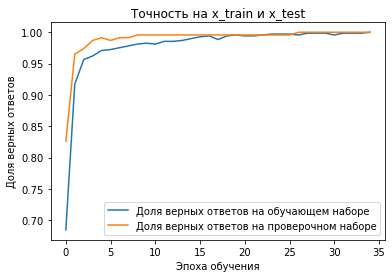

In [62]:
##############
# Обучение НС.
##############

history = model.fit(x_train,
                    y_train,
                    epochs=35,
                    batch_size=20,
                    validation_data=(x_test, y_test), verbose = None)

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Точность на x_train и x_test')
plt.legend()
plt.show()

In [353]:
model.save_weights('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/model_weights.h5')

In [138]:
model03 = create_model()

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [139]:
model03.load_weights('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/model_weights.h5')

# Подготовка тестовой выборки

In [13]:
!pip install subprocess

ERROR: Could not find a version that satisfies the requirement subprocess (from versions: none)
ERROR: No matching distribution found for subprocess


In [8]:
from pydub import AudioSegment

In [16]:
sound = AudioSegment.from_mp3('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Test_sounds/class5 psk50.mp3')

FileNotFoundError: [WinError 2] Не удается найти указанный файл

**У меня не получилось средствами python конвертировать mp3 в wav, поэтому я использовал онлайн сервис:
https://convertio.co/ru/wav-mp3/**

## Формирование X_test

In [79]:
num_class_dict

{'psk_50': 0,
 'psk_100': 1,
 'noises': 2,
 'voises': 3,
 'back_noise': 4,
 'data_no_sound': 5}

## psk_50

In [63]:
list_names = os.listdir('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Test_sounds/Convert')
main_path = 'C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Test_sounds/Convert/'

In [64]:
list_names

['1_class5-psk50_test.wav',
 '2_class1-psk100_test.wav',
 '3_class-6-postshum_test.wav',
 '4_class-2-golosa_test.wav',
 '5_class3-fon_test.wav',
 '6_class4_microphoneout_test.wav']

**Возьмём длину тестовых треков в 27 секунд, чтобы исключить возможность появления треков разной длины**

In [65]:
######################################################
# Функция получения массива данных по текущему классу.
######################################################

def wav_to_data(audio_path, name):
    
    '''
    Входные параметры: 
    - audio_path - название тестового трека текущего класса
    - name - ключ по которому определяется массив с данными текущего класса

    '''        
    x, sr = librosa.load(main_path + audio_path)
    
    hight = 27 * sr
    
    data = x[:hight]

    data_dict_test[name] = data
 
    

In [66]:
num_class_dict

{'psk_50': 0,
 'psk_100': 1,
 'noises': 2,
 'voises': 3,
 'back_noise': 4,
 'data_no_sound': 5}

In [67]:
data_dict_test = {}

In [68]:
###############################################
# Формирование массивов данных по ВСЕМ классам.
###############################################

for name, index in num_class_dict.items():
    wav_to_data(list_names[index], name)

In [69]:
data_dict_test

{'psk_50': array([-0.08795166, -0.00296021, -0.0199585 , ...,  0.28656006,
         0.16952515, -0.4085083 ], dtype=float32),
 'psk_100': array([ 0.8630066 ,  0.4156494 , -0.51083374, ..., -0.37298584,
        -0.31710815, -0.19003296], dtype=float32),
 'noises': array([-0.7191162 ,  0.77978516,  0.96710205, ..., -0.3350525 ,
         0.11294556,  0.6770325 ], dtype=float32),
 'voises': array([-0.0201416 , -0.07281494,  0.02502441, ...,  0.21109009,
        -0.11541748, -0.44308472], dtype=float32),
 'back_noise': array([0.05410767, 0.09222412, 0.07339478, ..., 0.06195068, 0.03189087,
        0.01217651], dtype=float32),
 'data_no_sound': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

In [70]:
##########################
# Получаем сэплы и лэйблы.
##########################

x_samples_t, y_lables_t = samples_lables(data_dict_test, 3*sr, 2*sr,)

In [71]:
x_samples_t.shape

(78, 66150)

In [72]:
y_lables_t.shape

(78,)

In [73]:
############################
# Получаем тестовую выборку.
############################

X_test = []

for sample in tqdm_notebook(x_samples_t):
    feature = get_features(sample, sr)
    X_test.append(feature)
    
X_test = np.array(X_test)
print(X_test.shape)

C:\Users\user\AppData\Local\Temp/ipykernel_380/688900581.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(x_samples_t):


  0%|          | 0/78 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(78, 37)


**Нормируем X_test тем же scaler, чтобы исключить рассогласованность в данных**

In [74]:
X_test = scaler.fit_transform(X_test)

In [75]:
X_test[0]

array([ 0.85718246,  0.76295536,  0.31629507,  0.52090991,  0.87307035,
        0.52658951, -1.06971968, -0.10174457, -0.11078555, -0.82184854,
        0.29336546, -0.7142153 ,  0.20215603, -0.45809045, -0.01207037,
        0.05731113, -0.48263479, -0.55872211,  0.3588071 , -0.51420985,
        0.35905873, -0.29131207,  0.3422824 , -0.86003312,  1.0045753 ,
       -0.23795595,  0.00500475, -0.22451768,  0.17493284,  0.5666095 ,
        0.44842598,  0.07451906,  0.85267678,  0.4617724 , -0.42009426,
       -0.56103467, -0.56014893])

In [76]:
####################
# y_lables_t -> OHE.
####################

Y_test = utils.to_categorical(y_lables_t, 6)


# Проверка точности предсказания модели на тестовой выборке

In [96]:
model03 = create_model()
model03.load_weights('C:/Users/user/Desktop/Тестовые/Задание ServiceNeuro/Решение/model_weights.h5')

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [97]:
prdict = model03.predict(X_test)

In [98]:
len(prdict)

78

In [99]:
prdict[0]

array([9.9925047e-01, 3.3094210e-04, 8.8706998e-05, 2.0865678e-05,
       1.9074530e-04, 1.1823568e-04], dtype=float32)

In [100]:
predict_class = np.argmax(prdict, axis=1)

In [101]:
predict_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

In [102]:
y_lables_t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## **Используем classification_report для удобного анализа качества предсказания**

In [149]:
print(classification_report(y_lables_t, predict_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       0.76      1.00      0.87        13
           4       1.00      0.69      0.82        13
           5       1.00      1.00      1.00        13

    accuracy                           0.95        78
   macro avg       0.96      0.95      0.95        78
weighted avg       0.96      0.95      0.95        78



In [150]:
num_class_dict

{'psk_50': 0,
 'psk_100': 1,
 'noises': 2,
 'voises': 3,
 'back_noise': 4,
 'data_no_sound': 5}

# **Из схемы classification_report можно сделать следующие выводы:**

- Класс 'voises'(голоса), не всега отличим от других классов, вероятно это связано с тем, что в речи бывают пробелы и НС принимает данные примеры за класс 'back_noise'(фоновый шум), т.к. в данном промежутке слышен только фон.

**Данную проблему можно решить увеличив длину оцениваемого куска аудио, например не 3 сек, а 5 сек или больше.**




- Класс 'back_noise' не всегда получаетс обнаружить нашей Нейронной сетью. Вероятно это связано с тем, что сеть, уловив пробелы в речи, в некоторых случаях игнорирует данных класс и определяет его как 'voises'.

**Данную проблему можно решить, подчистив примеры класса 'voises' от пробелов в речи.**
